In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score


random.seed(12)

data = pd.read_csv('/content/drive/MyDrive/thesis/Redo/feature selection/overlaping Optimal biomarkers evaluation/data/augmented_beta_severity_lfc_1_nosm_fake_neighbor_vectors_all_biomarkers_only.csv')

y_train = data.iloc[:, -1].values
X_train = data.iloc[:, :-1].values


#EVALUATION OF THE 215 FEATURES IN THE CGAN AUGMENTED DATASET
#RF with 5-fold cv evaluation of the cgan augmented dataset
clf_true = RandomForestClassifier(n_estimators=100 , random_state=42,)

# cv_scores_accuracy = cross_val_score(clf_true, X_train, y_train, cv=5)

# print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
# print("Mean Accuracy:", np.mean(cv_scores_accuracy))

# Cross-validation predictions
y_pred_cv = cross_val_predict(clf_true, X_train, y_train, cv=5)

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred_cv)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()

# Calculate Sensitivity and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Cross-validation accuracy
cv_scores_accuracy = cross_val_score(clf_true, X_train, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Accuracy:", np.mean(cv_scores_accuracy))
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Cross-Validation Accuracy Scores: [0.83783784 0.98198198 0.96396396 0.99090909 0.99090909]
Mean Accuracy: 0.9531203931203931
Sensitivity (Recall): 0.9644128113879004
Specificity: 0.9411764705882353


AUC-ROC: 0.9924442641825413


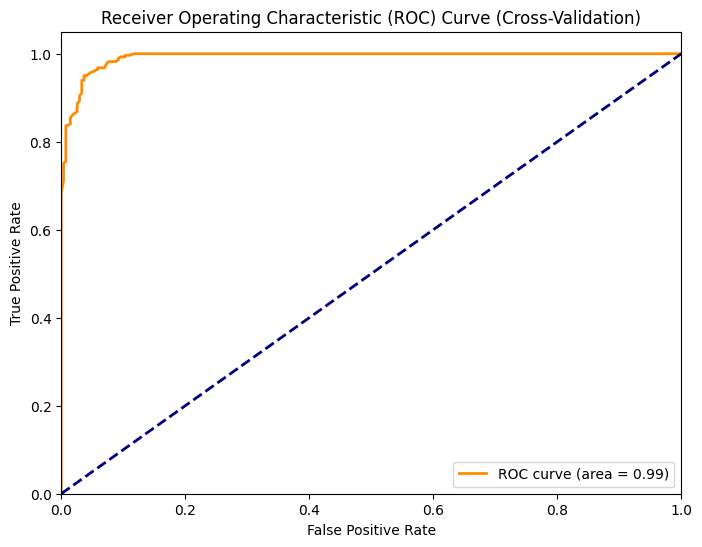

In [3]:
# ROC curve evaluation
y_true_prob_cv_true = cross_val_predict(clf_true, X_train, y_train, cv=5, method='predict_proba')[:, 1]

fpr_cv_true, tpr_cv_true, thresholds_cv_true = roc_curve(y_train, y_true_prob_cv_true)

roc_auc_cv_true = roc_auc_score(y_train, y_true_prob_cv_true)

print("AUC-ROC:", roc_auc_cv_true)


plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_true, tpr_cv_true, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_true))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

In [4]:
# Top 5 features
cv_results_true = cross_validate(clf_true, X_train, y_train, cv=5, return_train_score=False, return_estimator=True)

clf_true_fitted = cv_results_true['estimator'][-1]

feature_importances = clf_true_fitted.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': data.columns[:-1], 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_5_features = feature_importance_df.head(5)

print("Top 5 Features:")
print(top_5_features)


Top 5 Features:
    Feature  Importance
26   CCDC65    0.062765
210  ZNF239    0.056777
134  OTUD7A    0.054512
40   CEP126    0.041386
188   TCTN2    0.036861


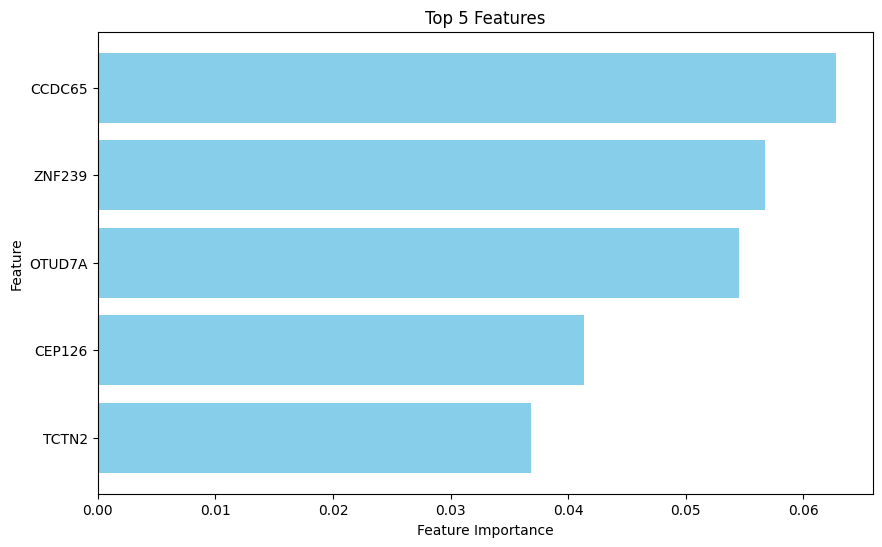

In [5]:
# Plotting the top5 features
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Features')
plt.gca().invert_yaxis()
plt.show()

Top 10 Features:
      Feature  Importance
26     CCDC65    0.062765
210    ZNF239    0.056777
134    OTUD7A    0.054512
40     CEP126    0.041386
188     TCTN2    0.036861
100  KIAA1671    0.036148
43      CLIC5    0.035017
171   SLC4A10    0.034164
112    MAGEE1    0.029251
145     PTCH1    0.028963


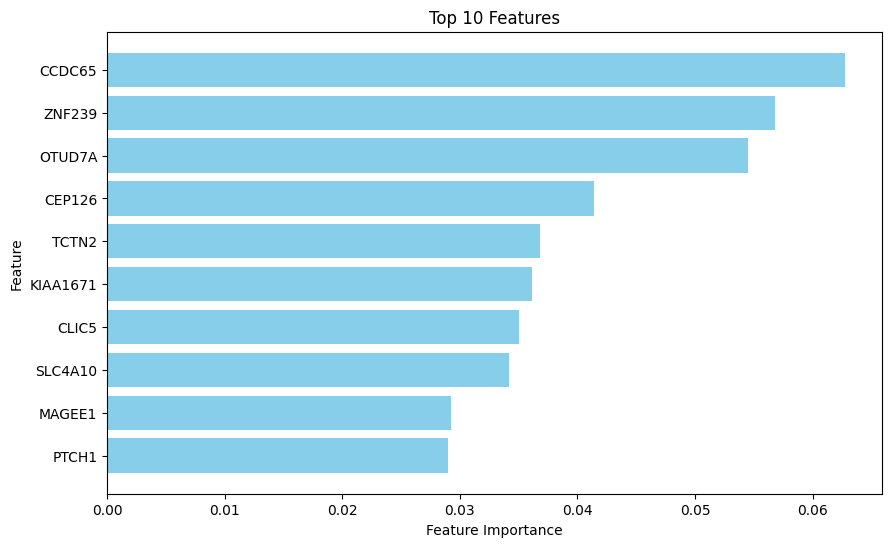

In [6]:
# plotting the  top 10 features

top_10_features = feature_importance_df.head(10)

print("Top 10 Features:")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()
plt.show()

In [8]:
#EVALUATION OF THE TOP5 FEATURES USING A RF CLASSIFIER ON THE CGAN AUGMENTED DATASET

# RF using only the top 5 features, evaluation with 5-fold cross validation
import joblib

# Train a Random Forest classifier using only the top 5 features
clf_top5 = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_top5 = data[top_5_features['Feature']].values

# Calculate accuracy using cross-validation
cv_scores_accuracy_top5 = cross_val_score(clf_top5, X_train_top5, y_train, cv=5, scoring='accuracy')

# Calculate the mean accuracy
mean_accuracy_top5 = np.mean(cv_scores_accuracy_top5)

# Calculate the mean cross-validated AUC
mean_auc_top5 = np.mean(cross_val_score(clf_top5, X_train_top5, y_train, cv=5, scoring='roc_auc'))


# Fit the model on the  dataset of top features
clf_top5.fit(X_train_top5, y_train)

# Save the trained model to a file
model_filename = '/content/drive/MyDrive/thesis/Redo/feature selection/overlaping Optimal biomarkers evaluation/data/Final_rf_model_top5_features_severity.joblib'
joblib.dump(clf_top5, model_filename)

# Print mean accuracy and a message indicating that the model is saved
print("Mean Cross-Validated Accuracy:", mean_accuracy_top5)
print("Mean Cross-Validated AUC:", mean_auc_top5)
print(f"Model saved as {model_filename}")



Mean Cross-Validated Accuracy: 0.9404750204750204
Mean Cross-Validated AUC: 0.9766098959520013
Model saved as /content/drive/MyDrive/thesis/Redo/feature selection/overlaping Optimal biomarkers evaluation/data/Final_rf_model_top5_features_severity.joblib


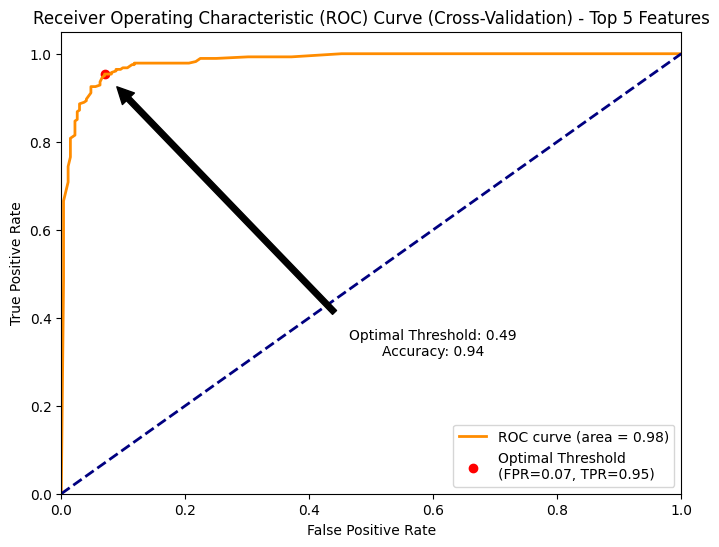

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict
import numpy as np

# Obtain predicted probabilities using cross-validation
y_true_prob_cv_top5 = cross_val_predict(clf_top5, X_train_top5, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate the ROC curve
fpr_cv_top5, tpr_cv_top5, thresholds_cv_top5 = roc_curve(y_train, y_true_prob_cv_top5)

# Calculate the AUC (Area Under the Curve) for ROC
roc_auc_cv_top5 = roc_auc_score(y_train, y_true_prob_cv_top5)

# Find optimal threshold (you may adjust this based on your specific criteria)
optimal_threshold_index = np.argmax(tpr_cv_top5 - fpr_cv_top5)
optimal_threshold = thresholds_cv_top5[optimal_threshold_index]

# Calculate accuracy based on the optimal threshold
y_pred_optimal = (y_true_prob_cv_top5 >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(y_train, y_pred_optimal)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_top5, tpr_cv_top5, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_top5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_cv_top5[optimal_threshold_index], tpr_cv_top5[optimal_threshold_index], color='red', marker='o',
            label=f'Optimal Threshold\n(FPR={fpr_cv_top5[optimal_threshold_index]:.2f}, TPR={tpr_cv_top5[optimal_threshold_index]:.2f})')

# Annotate the optimal threshold and accuracy
plt.annotate(f'Optimal Threshold: {optimal_threshold:.2f}\nAccuracy: {optimal_accuracy:.2f}',
             xy=(fpr_cv_top5[optimal_threshold_index], tpr_cv_top5[optimal_threshold_index]),
             xytext=(0.6, 0.3), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation) - Top 5 Features')
plt.legend(loc="lower right")
plt.show()


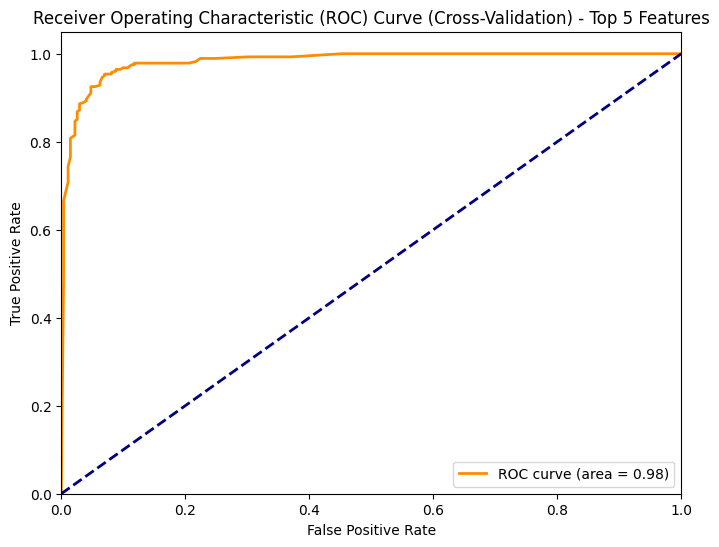

In [11]:
# ROC curve evaluation of the top 5 features
y_true_prob_cv_top5 = cross_val_predict(clf_top5, X_train_top5, y_train, cv=5, method='predict_proba')[:, 1]

fpr_cv_top5, tpr_cv_top5, thresholds_cv_top5 = roc_curve(y_train, y_true_prob_cv_top5)

roc_auc_cv_top5 = roc_auc_score(y_train, y_true_prob_cv_top5)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_top5, tpr_cv_top5, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_top5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation) - Top 5 Features')
plt.legend(loc="lower right")
plt.show()

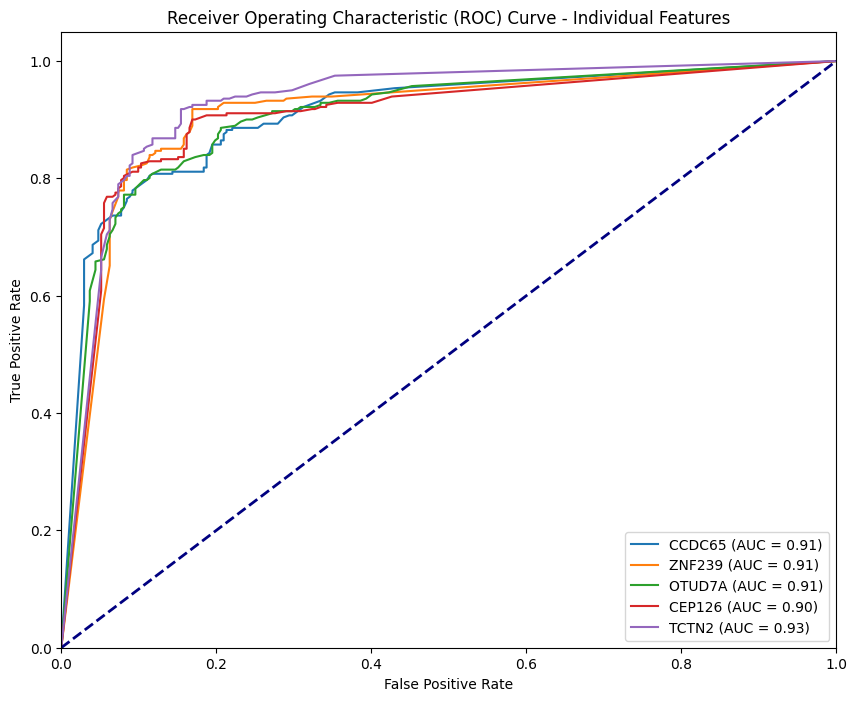

In [12]:
# ROC curve of the top 5 fetaures evaluated individually

plt.figure(figsize=(10, 8))
for i, feature in enumerate(top_5_features['Feature']):
    X_train_single_feature = data[[feature]].values
    y_true_prob_cv_single_feature = cross_val_predict(clf_top5, X_train_single_feature, y_train, cv=5, method='predict_proba')[:, 1]

    fpr_cv_single_feature, tpr_cv_single_feature, _ = roc_curve(y_train, y_true_prob_cv_single_feature)

    auc_value = roc_auc_score(y_train, y_true_prob_cv_single_feature)

    plt.plot(fpr_cv_single_feature, tpr_cv_single_feature, label=f'{feature} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Individual Features')

plt.legend(loc="lower right")
plt.show()

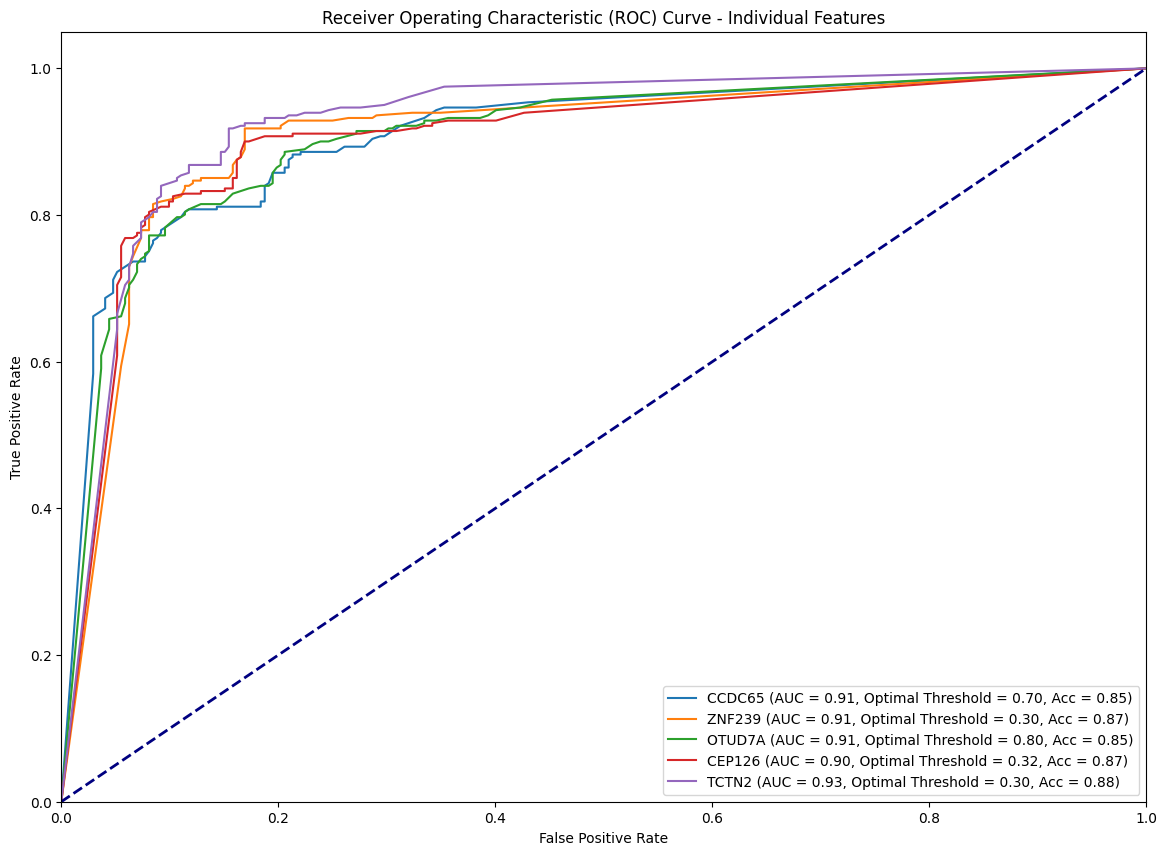

In [13]:
# Plot ROC curve for each individual feature
plt.figure(figsize=(14, 10))
for i, feature in enumerate(top_5_features['Feature']):
    # Train a model using only the current feature
    X_train_single_feature = data[[feature]].values
    y_true_prob_cv_single_feature = cross_val_predict(clf_top5, X_train_single_feature, y_train, cv=5, method='predict_proba')[:, 1]

    # Calculate the ROC curve
    fpr_cv_single_feature, tpr_cv_single_feature, thresholds_cv_single_feature = roc_curve(y_train, y_true_prob_cv_single_feature)

    # Find optimal threshold
    optimal_threshold_index = np.argmax(tpr_cv_single_feature - fpr_cv_single_feature)
    optimal_threshold = thresholds_cv_single_feature[optimal_threshold_index]

    # Calculate metrics at optimal threshold
    optimal_accuracy = (tpr_cv_single_feature[optimal_threshold_index] + (1 - fpr_cv_single_feature[optimal_threshold_index])) / 2
    # optimal_ppv = tpr_cv_single_feature[optimal_threshold_index] / (tpr_cv_single_feature[optimal_threshold_index] + fpr_cv_single_feature[optimal_threshold_index])
    # optimal_npv = (1 - fpr_cv_single_feature[optimal_threshold_index]) / (1 - tpr_cv_single_feature[optimal_threshold_index])

    # Plot the ROC curve for the current feature with legend
    plt.plot(fpr_cv_single_feature, tpr_cv_single_feature, label=f'{feature} (AUC = {roc_auc_score(y_train, y_true_prob_cv_single_feature):.2f}, Optimal Threshold = {optimal_threshold:.2f}, Acc = {optimal_accuracy:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Individual Features')

plt.legend(loc="lower right")
plt.show()


In [14]:
#testing overfitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Assuming clf_top5 is your trained model
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_top5, y_train, test_size=0.2, random_state=42)

# Train the model on the training set
clf_top5.fit(X_train, y_train)

# Obtain predicted probabilities on the test set
y_test_prob = clf_top5.predict_proba(X_test)[:, 1]

# Calculate AUC on the test set
test_auc = roc_auc_score(y_test, y_test_prob)

# Obtain predicted probabilities on the training set
y_train_prob = clf_top5.predict_proba(X_train)[:, 1]

# Calculate AUC on the training set
train_auc = roc_auc_score(y_train, y_train_prob)

# Print the AUC scores
print(f'Training AUC: {train_auc:.4f}')
print(f'Test AUC: {test_auc:.4f}')


Training AUC: 1.0000
Test AUC: 0.9738
